# 02: Modeling

**Purpose:** Train and evaluate models (classification for backorder/overstock; optional regression). Uses scikit-learn, xgboost, lightgbm, catboost. Save artifacts to `../models/`.

**Inputs:** `../data/processed/master_order_fulfillment_with_targets.csv`, `master_inventory_material_with_targets.csv` (from 01_eda_targets)

**Outputs:** Trained models, metrics, figures in `../models/` and `../output/`.

In [1]:
# Setup: paths and imports
# -----------------------------------------------------------------------------
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

_cwd = os.getcwd()
PROJECT_ROOT = os.path.dirname(_cwd) if os.path.basename(_cwd) == "notebooks" else _cwd
PROCESSED = os.path.join(PROJECT_ROOT, "data", "processed")
MODELS_DIR = os.path.join(PROJECT_ROOT, "models")
REPORTS_FIG = os.path.join(PROJECT_ROOT, "output", "figures")
REPORTS_TABLES = os.path.join(PROJECT_ROOT, "output", "tables")
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_FIG, exist_ok=True)
os.makedirs(REPORTS_TABLES, exist_ok=True)

try:
    plt.style.use("seaborn-v0_8-whitegrid")
except OSError:
    plt.style.use("seaborn-whitegrid")
sns.set_theme(style="whitegrid", palette="husl", font_scale=1.1)

In [2]:
# Load order data with targets
# -----------------------------------------------------------------------------
order = pd.read_csv(os.path.join(PROCESSED, "master_order_fulfillment_with_targets.csv"), low_memory=False)
print("Order shape:", order.shape)
print("target_backorder_risk distribution:")
print(order["target_backorder_risk"].value_counts())
print("Class balance:", order["target_backorder_risk"].mean() * 100, "% positive")

Order shape: (52118, 42)
target_backorder_risk distribution:
target_backorder_risk
0    46737
1     5381
Name: count, dtype: int64
Class balance: 10.32464791434821 % positive


In [3]:
# Feature preparation for backorder classification
# -----------------------------------------------------------------------------
# Numeric features (exclude target and identifiers)
NUMERIC_FEATURES = [
    "outstanding_qty", "saleable_inventory", "cumulative_order_quantity",
    "total_quantity_delivered", "net_value", "backorder_aging_days",
]
CATEGORICAL_FEATURES = ["material_type", "item_category"]

df = order.copy()
# Fill NaN for numeric
NUMERIC_FEATURES = [c for c in NUMERIC_FEATURES if c in df.columns]
for c in NUMERIC_FEATURES:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# Handle material_type, item_category (label encode for tree; one-hot optional for logistic)
df["material_type"] = df["material_type"].fillna("").astype(str).str[:20]
df["item_category"] = df["item_category"].fillna("").astype(str).str[:20]

# Simple label encoding for categoricals
from sklearn.preprocessing import LabelEncoder
le_mt = LabelEncoder()
le_ic = LabelEncoder()
df["material_type_enc"] = le_mt.fit_transform(df["material_type"].astype(str))
df["item_category_enc"] = le_ic.fit_transform(df["item_category"].astype(str))

FEATURE_COLS = [c for c in NUMERIC_FEATURES if c in df.columns] + ["material_type_enc", "item_category_enc"]
X = df[FEATURE_COLS].copy()
X = X.fillna(0)
y = df["target_backorder_risk"]

# Drop rows with any inf
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
mask = y.notna()
X, y = X[mask], y[mask].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Feature cols:", FEATURE_COLS)
print("Train size:", len(X_train), "Test size:", len(X_test))

Feature cols: ['outstanding_qty', 'saleable_inventory', 'cumulative_order_quantity', 'total_quantity_delivered', 'net_value', 'backorder_aging_days', 'material_type_enc', 'item_category_enc']
Train size: 41694 Test size: 10424


In [4]:
# Logistic regression (baseline)
# -----------------------------------------------------------------------------
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42,
)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression - Test metrics:")
print("  Accuracy:", accuracy_score(y_test, y_pred_lr))
print("  Precision:", precision_score(y_test, y_pred_lr, zero_division=0))
print("  Recall:", recall_score(y_test, y_pred_lr, zero_division=0))
print("  F1:", f1_score(y_test, y_pred_lr, zero_division=0))
print("  ROC-AUC:", roc_auc_score(y_test, y_proba_lr) if len(np.unique(y_test)) > 1 else 0)

Logistic Regression - Test metrics:
  Accuracy: 0.8996546431312357
  Precision: 0.5071633237822349
  Recall: 0.9869888475836431


  F1: 0.670031545741325
  ROC-AUC: 0.9101097902976681


In [5]:
# Random Forest (tree-based)
# -----------------------------------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
)
rf.fit(X_train, y_train)  # tree models don't need scaling
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest - Test metrics:")
print("  Accuracy:", accuracy_score(y_test, y_pred_rf))
print("  Precision:", precision_score(y_test, y_pred_rf, zero_division=0))
print("  Recall:", recall_score(y_test, y_pred_rf, zero_division=0))
print("  F1:", f1_score(y_test, y_pred_rf, zero_division=0))
print("  ROC-AUC:", roc_auc_score(y_test, y_proba_rf) if len(np.unique(y_test)) > 1 else 0)

Random Forest - Test metrics:
  Accuracy: 0.999712202609363
  Precision: 0.9981429897864438
  Recall: 0.9990706319702602
  F1: 0.9986065954482118
  ROC-AUC: 0.9999994034865022


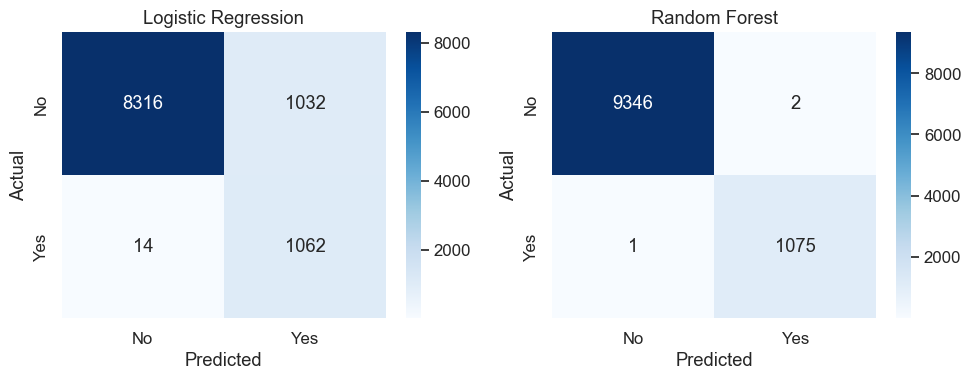


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

No Backorder       1.00      0.89      0.94      9348
   Backorder       0.51      0.99      0.67      1076

    accuracy                           0.90     10424
   macro avg       0.75      0.94      0.81     10424
weighted avg       0.95      0.90      0.91     10424

Classification Report - Random Forest:
              precision    recall  f1-score   support

No Backorder       1.00      1.00      1.00      9348
   Backorder       1.00      1.00      1.00      1076

    accuracy                           1.00     10424
   macro avg       1.00      1.00      1.00     10424
weighted avg       1.00      1.00      1.00     10424



In [6]:
# Confusion matrices and classification reports
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, y_pred, title in [
    (axes[0], y_pred_lr, "Logistic Regression"),
    (axes[1], y_pred_rf, "Random Forest"),
]:
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_FIG, "classification_confusion_matrices.png"), dpi=150, bbox_inches="tight")
plt.show()

print("\nClassification Report - Logistic Regression:")
print(classification_report(y_test, y_pred_lr, target_names=["No Backorder", "Backorder"]))
print("Classification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=["No Backorder", "Backorder"]))

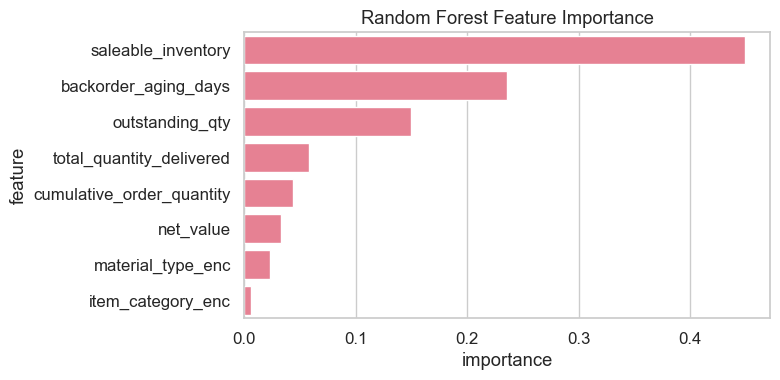

In [7]:
# Feature importance (Random Forest)
# -----------------------------------------------------------------------------
fi = pd.DataFrame({"feature": FEATURE_COLS, "importance": rf.feature_importances_}).sort_values("importance", ascending=False)
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=fi, x="importance", y="feature", ax=ax)
ax.set_title("Random Forest Feature Importance")
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_FIG, "classification_feature_importance.png"), dpi=150, bbox_inches="tight")
plt.show()
fi.to_csv(os.path.join(REPORTS_TABLES, "classification_feature_importance.csv"), index=False)

In [8]:
# Save models and metrics
# -----------------------------------------------------------------------------
metrics = {
    "logistic_regression": {
        "accuracy": float(accuracy_score(y_test, y_pred_lr)),
        "precision": float(precision_score(y_test, y_pred_lr, zero_division=0)),
        "recall": float(recall_score(y_test, y_pred_lr, zero_division=0)),
        "f1": float(f1_score(y_test, y_pred_lr, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_test, y_proba_lr)) if len(np.unique(y_test)) > 1 else 0,
    },
    "random_forest": {
        "accuracy": float(accuracy_score(y_test, y_pred_rf)),
        "precision": float(precision_score(y_test, y_pred_rf, zero_division=0)),
        "recall": float(recall_score(y_test, y_pred_rf, zero_division=0)),
        "f1": float(f1_score(y_test, y_pred_rf, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_test, y_proba_rf)) if len(np.unique(y_test)) > 1 else 0,
    },
}
with open(os.path.join(MODELS_DIR, "classification_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved classification_metrics.json")

joblib.dump(lr, os.path.join(MODELS_DIR, "backorder_logistic.joblib"))
joblib.dump(rf, os.path.join(MODELS_DIR, "backorder_random_forest.joblib"))
joblib.dump(scaler, os.path.join(MODELS_DIR, "scaler.joblib"))
print("Saved models and scaler")

Saved classification_metrics.json
Saved models and scaler


---
## Regression and Forecasting

Demand forecasts from shipment history (AWD proxy). Overstock/excess from WOC.

In [9]:
# Demand forecasting: regression with time features
# -----------------------------------------------------------------------------
shipment = pd.read_csv(os.path.join(PROCESSED, "shipment_history.csv"), low_memory=False)
shipment["shipment_week"] = pd.to_datetime(shipment["shipment_week"], errors="coerce")
shipment = shipment.dropna(subset=["shipment_week", "quantity_shipped"])
shipment["quantity_shipped"] = pd.to_numeric(shipment["quantity_shipped"], errors="coerce").fillna(0)

# Aggregate demand by material (and plant) per week
demand_agg = (
    shipment.groupby(["client_id", "material_number", "plant_code", "shipment_week"], dropna=False)["quantity_shipped"]
    .sum()
    .reset_index()
)
demand_agg["week_of_year"] = demand_agg["shipment_week"].dt.isocalendar().week.astype(int)

# Simple forecast: mean demand per material over last 12 weeks
WINDOW = 12
demand_agg = demand_agg.sort_values("shipment_week")
demand_agg["roll_mean"] = (
    demand_agg.groupby(["client_id", "material_number", "plant_code"])["quantity_shipped"]
    .transform(lambda x: x.rolling(WINDOW, min_periods=1).mean())
)
# Latest forecast per material
forecast_df = (
    demand_agg.groupby(["client_id", "material_number", "plant_code"])
    .apply(lambda g: g.sort_values("shipment_week").iloc[-1][["roll_mean", "shipment_week"]])
    .reset_index()
)
forecast_df = forecast_df.rename(columns={"roll_mean": "demand_forecast", "shipment_week": "forecast_as_of"})
forecast_df.to_csv(os.path.join(REPORTS_TABLES, "demand_forecast.csv"), index=False)
print("Demand forecast saved. Sample:")
print(forecast_df.head(10))

Demand forecast saved. Sample:
   client_id     material_number plant_code  demand_forecast forecast_as_of
0         50  000000000000000004       1000         9.000000     2022-01-10
1         50            C0000001       1000       117.000000     2022-04-11
2         50            C0000001       2000        24.500000     2022-03-28
3         50            C0000001       3000       149.200000     2022-03-28
4         50            C0000001       4000       136.166667     2022-04-04
5         50            C0000001       5000       249.625000     2022-04-11
6         50            C0000002       1000       194.375000     2022-04-04
7         50            C0000002       2000        42.800000     2022-03-28
8         50            C0000002       3000       316.400000     2022-03-28
9         50            C0000002       4000       252.666667     2022-04-04


/var/folders/mp/ffkpv4tj1t90x9x4wtn_by4w0000gn/T/ipykernel_94880/3725413582.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  demand_agg.groupby(["client_id", "material_number", "plant_code"])


In [10]:
# Excess inventory (overstock): numeric estimate from WOC
# -----------------------------------------------------------------------------
woc = pd.read_csv(os.path.join(PROCESSED, "master_woc.csv"), low_memory=False)
# Excess = saleable - ideal; ideal = AWD * target_weeks (such as 8 weeks)
TARGET_WOC_WEEKS = 8
woc["awd"] = pd.to_numeric(woc["awd"], errors="coerce").fillna(0)
woc["saleable_inventory"] = pd.to_numeric(woc["saleable_inventory"], errors="coerce").fillna(0)
woc["ideal_inventory"] = woc["awd"] * TARGET_WOC_WEEKS
woc["excess_units"] = (woc["saleable_inventory"] - woc["ideal_inventory"]).clip(lower=0)
woc["excess_units"] = np.where(woc["awd"] <= 0, np.nan, woc["excess_units"])

excess_summary = woc[["client_id", "material_number", "plant_code", "saleable_inventory", "awd", "woc", "excess_units"]].copy()
excess_summary = excess_summary.dropna(subset=["excess_units"])
excess_summary.to_csv(os.path.join(REPORTS_TABLES, "excess_inventory.csv"), index=False)
print("Excess inventory saved. Materials with excess:", len(excess_summary[excess_summary["excess_units"] > 0]))
print("Sample:")
print(excess_summary[excess_summary["excess_units"] > 0].head(10))

Excess inventory saved. Materials with excess: 188
Sample:
    client_id material_number plant_code  saleable_inventory        awd  \
2         100        C0000001       1000              3379.0  27.958333   
3         100        C0000001       2000              2042.0   4.708333   
4         100        C0000001       3000              2313.0  12.583333   
5         100        C0000001       4000              2295.0  13.333333   
6         100        C0000001       5000              2001.0  27.041667   
7         100        C0000002       1000              2015.0  13.000000   
8         100        C0000002       2000              2026.0   5.166667   
9         100        C0000002       3000              2162.0  19.333333   
10        100        C0000002       4000              2169.0  18.875000   
11        100        C0000002       5000              2031.0  27.708333   

           woc  excess_units  
2   114.420268   3155.333333  
3   424.778761   2004.333333  
4   180.476821   2212.

In [11]:
# Save regression/forecast summary
# -----------------------------------------------------------------------------
regression_metrics = {
    "demand_forecast": {"materials_with_forecast": int(forecast_df["material_number"].nunique())},
    "excess_inventory": {
        "materials_with_excess": int((excess_summary["excess_units"] > 0).sum()),
        "total_excess_units": float(excess_summary["excess_units"].sum()),
    },
}
with open(os.path.join(MODELS_DIR, "regression_metrics.json"), "w") as f:
    json.dump(regression_metrics, f, indent=2)
print("Saved regression_metrics.json")

Saved regression_metrics.json
